In [375]:
import json
from collections import defaultdict
from sklearn import linear_model
import numpy as np
import random
import gzip
import dateutil.parser
import math

from sklearn.preprocessing import OneHotEncoder
from sklearn import metrics
import matplotlib.pyplot as plt

In [376]:
answers = {}

In [377]:
def assertFloat(x):
    assert type(float(x)) == float

def assertFloatList(items, N):
    assert len(items) == N
    assert [type(float(x)) for x in items] == [float]*N

In [378]:
### Question 1 - Regression

In [379]:
f = gzip.open("data/fantasy_10000.json.gz")
dataset = []
for l in f:
    dataset.append(json.loads(l))

In [380]:
def feature(datum):
    review_lengths = []
    review_ratings = []

    for review in datum:
        review_lengths.append([len(review['review_text'])])
        review_ratings.append(review['rating'])
        
    # Scale review lengths
    review_lengths = review_lengths / np.max(review_lengths)

    return review_lengths, review_ratings

In [381]:
X = feature(dataset)[0]
Y = feature(dataset)[1]

In [382]:
# Instantiate model

reg = linear_model.LinearRegression().fit(X, Y)

In [383]:
theta = (reg.intercept_, reg.coef_[0])

In [384]:
# Get MSE

preds = reg.predict(X)
MSE = np.sum((Y - preds)**2) / len(preds)

In [385]:
# Sanity check

from sklearn import metrics
metrics.mean_squared_error(Y, preds)

1.5522086622355378

In [386]:
answers['Q1'] = [theta[0], theta[1], MSE]

In [387]:
assertFloatList(answers['Q1'], 3)

In [388]:
### Question 2

In [389]:
for d in dataset:
    t = dateutil.parser.parse(d['date_added'])
    d['parsed_date'] = t

In [390]:
# Manually write out feature vector for first two reviews

# [1, 0.14581295, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
# [1, 0.10631903, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

In [391]:
def feature(datum):
    review_lengths = []
    review_ratings = []
    weekdays = []
    months = []
    offset_term = [[1]]*len(datum)

    for review in datum:
        review_lengths.append([len(review['review_text'])])
        review_ratings.append(review['rating'])
        weekdays.append([review['parsed_date'].weekday()])
        months.append([review['parsed_date'].month])
    
    # Scale review lengths
    review_lengths = review_lengths / np.max(review_lengths)

    # One-hot encode weekdays
    weekday_enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    weekday_enc.fit(weekdays)
    weekdays_ohe = weekday_enc.transform(weekdays).toarray()

    # One-hot encode months
    month_enc = OneHotEncoder(drop='first', handle_unknown='ignore')
    month_enc.fit(months)
    month_ohe = month_enc.transform(months).toarray()

    return np.hstack((offset_term, review_lengths, weekdays_ohe, month_ohe)), \
        review_ratings

In [392]:
X_q2 = feature(dataset)[0]
Y_q2 = feature(dataset)[1]

In [393]:
answers['Q2'] = [list(X_q2[0]), list(X_q2[1])]

In [394]:
assertFloatList(answers['Q2'][0], 19)
assertFloatList(answers['Q2'][1], 19)

In [395]:
### Question 3

In [396]:
def feature3(datum):
    review_lengths = []
    review_ratings = []
    weekdays = []
    months = []

    for review in datum:
        review_lengths.append([len(review['review_text'])])
        review_ratings.append(review['rating'])
        weekdays.append([review['parsed_date'].weekday()])
        months.append([review['parsed_date'].month])
        
    # Scale review lengths
    review_lengths = review_lengths / np.max(review_lengths)

    return np.hstack((review_lengths, weekdays, months)), review_ratings

In [397]:
X3 = feature3(dataset)[0]
Y3 = feature3(dataset)[1]

In [398]:
# Use weekday and month values directly

reg_raw = linear_model.LinearRegression(fit_intercept=True).fit(X3, Y3)
preds_raw = reg_raw.predict(X3)
mse3 = np.sum((Y3 - preds_raw)**2) / len(preds_raw)

# Use one-hot encoded features

reg_q2 = linear_model.LinearRegression(fit_intercept=False).fit(X_q2, Y_q2)
preds_q2 = reg_q2.predict(X_q2)
mse2 = np.sum((Y_q2 - preds_q2)**2) / len(preds_q2)

In [399]:
answers['Q3'] = [mse2, mse3]

In [400]:
assertFloatList(answers['Q3'], 2)

In [401]:
### Question 4

In [402]:
random.seed(0)
random.shuffle(dataset)

In [403]:
# X2 = [feature(d) for d in dataset]
X2 = feature(dataset)[0]
# X3 = [feature3(d) for d in dataset]
X3 = feature3(dataset)[0]
Y = [d['rating'] for d in dataset]

In [404]:
train2, test2 = X2[:len(X2)//2], X2[len(X2)//2:]
train3, test3 = X3[:len(X3)//2], X3[len(X3)//2:]
trainY, testY = Y[:len(Y)//2], Y[len(Y)//2:]

In [405]:
# Train and evaluate one-hot encoding model (q2)

mdl_q2 = linear_model.LinearRegression(fit_intercept=False).fit(train2, trainY)
mdl_q2_preds = mdl_q2.predict(test2)
test_mse2 = np.sum((testY - mdl_q2_preds)**2) / len(mdl_q2_preds)

# Train and evaluate direct encoding model (q3)

mdl_q3 = linear_model.LinearRegression().fit(train3, trainY)
mdl_q3_preds = mdl_q3.predict(test3)
test_mse3 = np.sum((testY - mdl_q3_preds)**2) / len(mdl_q3_preds)

In [406]:
answers['Q4'] = [test_mse2, test_mse3]

In [407]:
assertFloatList(answers['Q4'], 2)

In [408]:
answers

{'Q1': [3.685681355016952, 0.9833539181066129, 1.5522086622355378],
 'Q2': [[1.0,
   0.14581294561722355,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [1.0,
   0.10631902698168601,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0]],
 'Q3': [1.546631549848756, 1.5516353711453328],
 'Q4': [1.6264453676167925, 1.6282919476176059]}

In [409]:
### Question 5

In [410]:
f = open("data/beer_50000.json")
dataset = []
for l in f:
    dataset.append(eval(l))

In [411]:
X = [[len(r['review/text'])] for r in dataset]
y = [r['review/overall'] >= 4 for r in dataset]

In [412]:
reg_q5 = linear_model.LogisticRegression(class_weight='balanced').fit(X, y)

In [413]:
preds_q5 = reg_q5.predict(X)

In [414]:
tn, fp, fn, tp = metrics.confusion_matrix(y, preds_q5).ravel()

In [415]:
TP = tp
TN = tn 
FP = fp
FN = fn

In [416]:
SEN = TP / (TP + FN)  # sensitivity / TPR 
FPR = FP / (FP + TN)  # FPR
SPE = TN / (TN + FP)  # specificity / TNR
BER = 0.5*(FPR + (1-SEN))

In [417]:
answers['Q5'] = [TP, TN, FP, FN, BER]

In [418]:
assertFloatList(answers['Q5'], 5)

In [419]:
answers

{'Q1': [3.685681355016952, 0.9833539181066129, 1.5522086622355378],
 'Q2': [[1.0,
   0.14581294561722355,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [1.0,
   0.10631902698168601,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0]],
 'Q3': [1.546631549848756, 1.5516353711453328],
 'Q4': [1.6264453676167925, 1.6282919476176059],
 'Q5': [14201, 10503, 5885, 19411, 0.46830315259572763]}

In [420]:
### Question 6

In [421]:
confidences = reg_q5.decision_function(X)

In [422]:
sortedByConfidence = list(zip(confidences, y))
sortedByConfidence.sort(reverse=True)

In [423]:
sortedByConfidence

[(1.4202038838937503, True),
 (1.4085230410033456, True),
 (1.3476410719988112, True),
 (1.3125985433275968, True),
 (1.2856972081860585, True),
 (1.2580879431723742, True),
 (1.2237533443733055, False),
 (1.1993297637842772, True),
 (1.180215657236342, True),
 (1.1741982533231032, False),
 (1.1710125688984474, True),
 (1.1572079363916052, True),
 (1.1430493389486904, True),
 (1.1409255493322532, False),
 (1.1338462506107956, True),
 (1.1338462506107956, True),
 (1.1062369855971115, True),
 (1.10482112585282, True),
 (1.0977418271313626, True),
 (1.079689615391646, True),
 (1.0623453335240751, True),
 (1.0619913685880022, True),
 (1.0605755088437108, True),
 (1.0496025958254518, True),
 (1.0389836477432655, True),
 (1.0269488399167879, True),
 (1.021285400939622, True),
 (1.0170378217067473, True),
 (0.9947380307341562, True),
 (0.9936761359259376, True),
 (0.9887206268209174, True),
 (0.9745620293780026, True),
 (0.9706684150812008, True),
 (0.9635891163597434, True),
 (0.962527221551

In [424]:
precs = []

In [425]:
for k in [1,100,1000,10000]:
    topK = sortedByConfidence[:k]
    prec = np.sum([1 if pred[1] else 0 for pred in topK]) / k
    precs.append(prec)

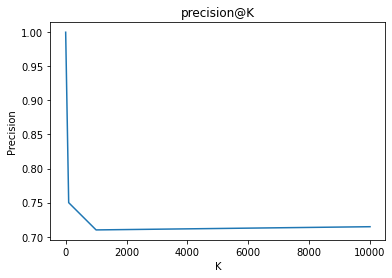

In [426]:
# Plot the precision@K 

plt.plot([1,100,1000,10000], precs)
plt.xlabel('K')
plt.ylabel('Precision')
plt.title('precision@K');

In [427]:
answers['Q6'] = precs

In [428]:
assertFloatList(answers['Q6'], 4)

In [429]:
answers

{'Q1': [3.685681355016952, 0.9833539181066129, 1.5522086622355378],
 'Q2': [[1.0,
   0.14581294561722355,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [1.0,
   0.10631902698168601,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0]],
 'Q3': [1.546631549848756, 1.5516353711453328],
 'Q4': [1.6264453676167925, 1.6282919476176059],
 'Q5': [14201, 10503, 5885, 19411, 0.46830315259572763],
 'Q6': [1.0, 0.75, 0.71, 0.7147]}

In [430]:
### Question 7

In [431]:
dataset[0]

{'review/appearance': 2.5,
 'beer/style': 'Hefeweizen',
 'review/palate': 1.5,
 'review/taste': 1.5,
 'beer/name': 'Sausa Weizen',
 'review/timeUnix': 1234817823,
 'beer/ABV': 5.0,
 'beer/beerId': '47986',
 'beer/brewerId': '10325',
 'review/timeStruct': {'isdst': 0,
  'mday': 16,
  'hour': 20,
  'min': 57,
  'sec': 3,
  'mon': 2,
  'year': 2009,
  'yday': 47,
  'wday': 0},
 'review/overall': 1.5,
 'review/text': 'A lot of foam. But a lot.\tIn the smell some banana, and then lactic and tart. Not a good start.\tQuite dark orange in color, with a lively carbonation (now visible, under the foam).\tAgain tending to lactic sourness.\tSame for the taste. With some yeast and banana.',
 'user/profileName': 'stcules',
 'review/aroma': 2.0}

In [432]:
type(dataset[0]['review/timeStruct']['year'])

int

In [433]:
# r['review/timeStruct']['hour']

In [434]:
X_q7 = [[len(r['review/text']), r['review/taste']] for r in dataset]
y_q7 = [r['review/overall'] >= 4 for r in dataset]

In [435]:
# Examine for linearity

text_len = []
taste_review = []

for datum in X_q7:
    text_len.append(datum[0])
    taste_review.append(datum[1])

# text_len.sort()
# taste_review.sort()

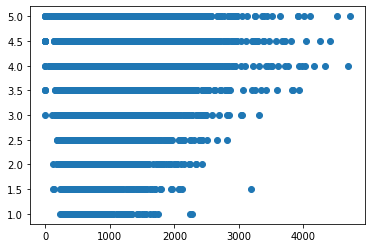

In [436]:
plt.scatter(text_len, taste_review)

In [437]:
reg_q7 = linear_model.LogisticRegression(class_weight='balanced').fit(X_q7, y_q7)

In [438]:
preds_q7 = reg_q7.predict(X_q7)
tn_q7, fp_q7, fn_q7, tp_q7 = metrics.confusion_matrix(y_q7, preds_q7).ravel()
SEN_q7 = tp_q7 / (tp_q7 + fn_q7)  # sensitivity / TPR 
FPR_q7 = fp_q7 / (fp_q7 + tn_q7)  # FPR
SPE_q7 = tn_q7 / (tn_q7 + fp_q7)  # specificity / TNR
BER_q7 = 0.5*(FPR_q7 + (1-SEN_q7))

In [439]:
BER_q7

0.1884975664949443

In [440]:
its_test_BER = BER_q7

In [441]:
reasoning = "I added the taste review as a second learning feature. My rationale"\
    +" is people's assessment/perception of the beer's taste will have a strong"\
    +" influence on the overall review score. I also plotted the two learning"\
    +" feature to check for feature association and there isn't seem to be any."

In [442]:
answers['Q7'] = [reasoning, its_test_BER]

In [443]:
answers

{'Q1': [3.685681355016952, 0.9833539181066129, 1.5522086622355378],
 'Q2': [[1.0,
   0.14581294561722355,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0],
  [1.0,
   0.10631902698168601,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   0.0,
   1.0,
   0.0,
   0.0,
   0.0]],
 'Q3': [1.546631549848756, 1.5516353711453328],
 'Q4': [1.6264453676167925, 1.6282919476176059],
 'Q5': [14201, 10503, 5885, 19411, 0.46830315259572763],
 'Q6': [1.0, 0.75, 0.71, 0.7147],
 'Q7': ["I added the taste review as a second learning feature. My rationale is people's assessment/perception of the beer's taste will have a strong influence on the overall review score. I also plotted the two learning feature to check for feature association and there isn't seem to be any.",
  0.1884975664949443]}

In [444]:
f = open("answers_hw1.txt", 'w')
f.write(str(answers) + '\n')
f.close()